PCA standard: 
 MSE = 1.00522 
 RMSE = 1.002607 

Sparse PCA (para = 10 ): 
 MSE = 1.005009 
 RMSE = 1.002501 


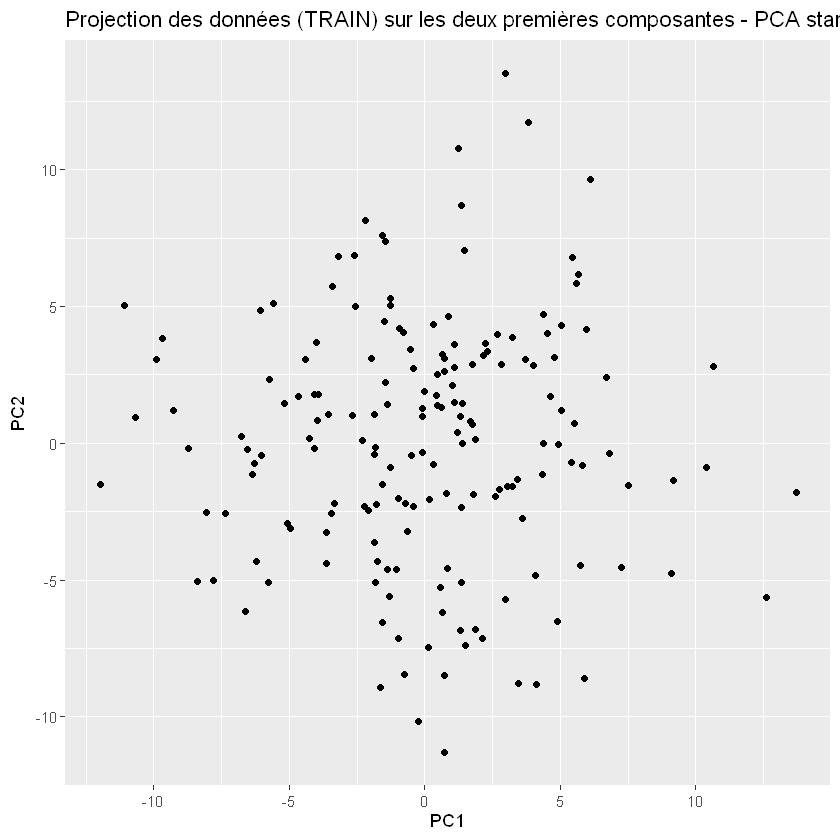

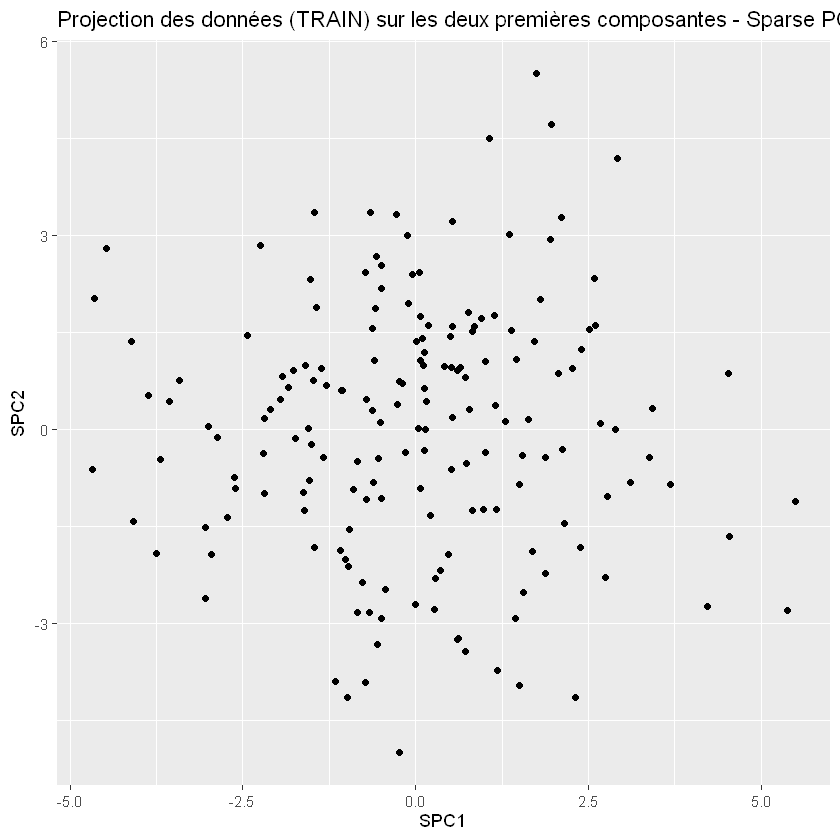

In [19]:
# Packages nécessaires
library(elasticnet)  # pour spca
library(ggplot2)

# Exemple minimaliste
set.seed(1253)
n <- 250
p <- 2200
X <- matrix(rnorm(n * p), nrow = n, ncol = p)

# Division en train/test
train_ratio <- 0.7
train_idx <- sample(1:n, size = floor(train_ratio * n))
X_train <- X[train_idx, ]
X_test <- X[-train_idx, ]

# Centrage et réduction du TRAIN
X_train_scaled <- scale(X_train, center = TRUE, scale = TRUE)
center_values <- attr(X_train_scaled, "scaled:center")
scale_values <- attr(X_train_scaled, "scaled:scale")

# PCA standard sur TRAIN
pca_res <- prcomp(X_train_scaled, center = FALSE, scale. = FALSE) 
# (déjà centré et réduit manuellement)

# Choix du nombre de composantes, par exemple 5
num_components <- 5

# Projection et reconstruction PCA standard sur TEST
X_test_scaled <- scale(X_test, center = center_values, scale = scale_values)
scores_pca_test <- X_test_scaled %*% pca_res$rotation[, 1:num_components]
X_test_reconstructed_pca_scaled <- scores_pca_test %*% t(pca_res$rotation[, 1:num_components])

# Retour à l'échelle originale
X_test_reconstructed_pca <- sweep(X_test_reconstructed_pca_scaled, 2, scale_values, "*")
X_test_reconstructed_pca <- sweep(X_test_reconstructed_pca, 2, center_values, "+")

# Calcul de l'erreur pour PCA standard
MSE_pca <- mean((X_test - X_test_reconstructed_pca)^2)
RMSE_pca <- sqrt(MSE_pca)

# Sparse PCA sur TRAIN (utilisation directe sur données prétraitées)
# Choix de la pénalisation, par exemple para = 10
para_val <- 10
spca_res <- spca(X_train_scaled, K = num_components, sparse = "penalty", 
                 para = rep(para_val, num_components), type = "predictor")

# Scores test en Sparse PCA
scores_spca_test <- X_test_scaled %*% spca_res$loadings

# Reconstruction Sparse PCA
X_test_reconstructed_spca_scaled <- scores_spca_test %*% t(spca_res$loadings)

# Retour à l'échelle originale
X_test_reconstructed_spca <- sweep(X_test_reconstructed_spca_scaled, 2, scale_values, "*")
X_test_reconstructed_spca <- sweep(X_test_reconstructed_spca, 2, center_values, "+")

# Calcul de l'erreur pour Sparse PCA
MSE_spca <- mean((X_test - X_test_reconstructed_spca)^2)
RMSE_spca <- sqrt(MSE_spca)

# Affichage des résultats
cat("PCA standard:", "\n",
    "MSE =", MSE_pca, "\n",
    "RMSE =", RMSE_pca, "\n\n")

cat("Sparse PCA (para =", para_val, "):", "\n",
    "MSE =", MSE_spca, "\n",
    "RMSE =", RMSE_spca, "\n")

# Visualisation rapide des deux premières composantes PCA standard
df_pca <- data.frame(PC1 = pca_res$x[,1], PC2 = pca_res$x[,2])
ggplot(df_pca, aes(x = PC1, y = PC2)) + 
  geom_point() + 
  ggtitle("Projection des données (TRAIN) sur les deux premières composantes - PCA standard")

# Visualisation Sparse PCA (num_components=2)
if (num_components >= 2) {
  df_spca <- data.frame(SPC1 = X_train_scaled %*% spca_res$loadings[,1],
                        SPC2 = X_train_scaled %*% spca_res$loadings[,2])
  ggplot(df_spca, aes(x = SPC1, y = SPC2)) + 
    geom_point() + 
    ggtitle("Projection des données (TRAIN) sur les deux premières composantes - Sparse PCA")
}
